In [1]:
import matplotlib.pyplot as plt
from collections import defaultdict

dict_losses = defaultdict(list)
with open("per_token_loss_2.txt", "r") as f:
    for line in f:
        if 'val' in line:
            continue
        losses = line.split('train')[-1].strip().split('|')
        for loss in losses:
            i, val = loss.strip().split(":")
            i = int(i)
            val = abs(float(val))
            dict_losses[i].append(val)

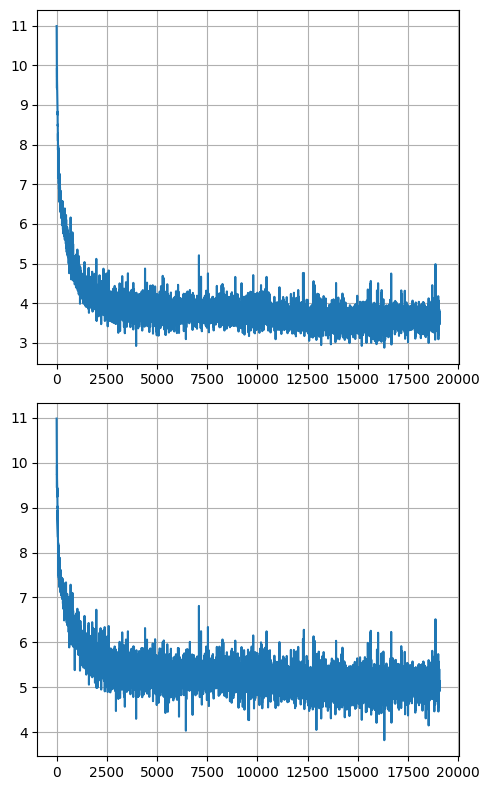

In [2]:
fig, axes = plt.subplots(nrows=len(dict_losses), ncols=1, figsize=(5, 4*len(dict_losses)))
gamma = 0.9
# Extract loss values from dictionary
for i in range(1, len(dict_losses)+1):
    dict_losses[i] = [val/(gamma**(i-1)) for val in dict_losses[i]]
    axes[i-1].plot(range(len(dict_losses[i])), dict_losses[i])
    axes[i-1].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [3]:
import torch
import tiktoken
from model import GPT

tokenizer = tiktoken.get_encoding("gpt2")
cpt = torch.load('cpt.pt', map_location='cpu', weights_only=False)
cpt.keys()

dict_keys(['model', 'config', 'step', 'val_loss'])

In [4]:
a = torch.tensor([1, 3, 2, 4, 5])
values, indices = torch.sort(a, descending=True)
print(values, indices)
a[indices[:2]]

tensor([5, 4, 3, 2, 1]) tensor([4, 3, 1, 2, 0])


tensor([5, 4])

In [5]:
a[0]

tensor(1)

In [6]:
model = GPT(cpt['config'])
model.load_state_dict(cpt['model'])

number of parameters: 162.22M


<All keys matched successfully>

In [7]:
from torch.nn import functional as F

def generate_and_print_next_k_tokens(
    seq: str,
    model: GPT,
    k: int=2,
    max_new_tokens: int = 10
) -> None:
    
    tokens = tokenizer.encode(seq)
    tokens = torch.tensor([tokens])

    for _ in range(max_new_tokens):
        logits = model(tokens)
        next_token_probs = F.softmax(logits[:, -1, :], dim=-1).squeeze()
        sorted_probs, indices = torch.sort(next_token_probs, descending=True)
        next_k_tokens = indices[:k]
        next_k_probs = sorted_probs[:k]
        # print(f'next_k_tokens: {next_k_tokens}')
        print(tokenizer.decode(tokens[0].tolist()), end='')
        for tok, prob in zip(next_k_tokens.tolist(), next_k_probs.tolist()):
            tok_s = tokenizer.decode([tok])
            print(f" | {tok_s}({prob:.4f})", end='')
        print()

        tokens = torch.cat(
            [tokens, torch.tensor([[next_k_tokens[0]]])], 
            dim=-1
        )
        # print(f'tokens: {tokens}')

In [8]:
generate_and_print_next_k_tokens(
    seq='how are',
    model=model,
    max_new_tokens=10
)

how are |  you(0.0575) |  they(0.0557)
how are you | ?(0.1184) |  to(0.0880)
how are you? | 
(0.1955) | �(0.0349)
how are you?
 | -(0.0922) |  you(0.0241)
how are you?
- |  What(0.1054) |  How(0.0551)
how are you?
- What |  is(0.1360) |  the(0.1162)
how are you?
- What is |  the(0.2870) |  your(0.0661)
how are you?
- What is the |  of(0.1053) |  between(0.0541)
how are you?
- What is the of |  the(0.1303) |  a(0.0567)
how are you?
- What is the of the | ?(0.0801) |  of(0.0770)
